In [ ]:
import sys
sys.path.insert(0, "..")

In [2]:
import relabel

In [3]:
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt

In [4]:
from dask.diagnostics import ProgressBar

In [5]:
from skimage.data import cells3d
from skimage import color

In [6]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

# Use the 3D Cells example from scikit-image

In [7]:
img = cells3d()[30, 1, :, :]

In [8]:
img.shape

(256, 256)

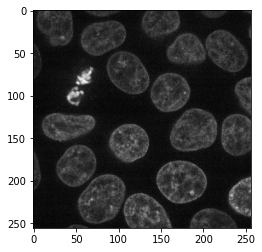

In [9]:
plt.imshow(img, cmap="gray")

## Load the Stardist model

In [10]:
import tensorflow as tf

In [11]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
model = StarDist2D.from_pretrained("2D_paper_dsb2018")

def stardist2d(im_chunk, model=None):
    labeled_image, _ = model.predict_instances(normalize(im_chunk, 1,99.8, axis=(0, 1)))
    labeled_image = labeled_image.astype(dtype=np.int32)
    return labeled_image

Found model '2D_paper_dsb2018' for 'StarDist2D'.
Loading network weights from 'weights_last.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.417819, nms_thresh=0.5.


2024-03-13 14:41:03.360349: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 14:41:03.921555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78693 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:89:00.0, compute capability: 8.0


In [13]:
%%time
labels_ref = stardist2d(img, model=model)

2024-03-13 14:41:06.138791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


CPU times: user 3.77 s, sys: 857 ms, total: 4.63 s
Wall time: 2.72 s


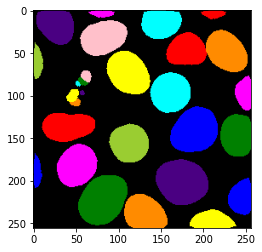

In [14]:
plt.imshow(color.label2rgb(labels_ref))

## Execute the segmentation and relabeling process

In [15]:
img_da = da.from_array(img, chunks=(128, 128))
img_da

dask.array<array, shape=(256, 256), dtype=uint16, chunksize=(128, 128), chunktype=numpy.ndarray>

In [16]:
%%time
labels = relabel.image2labels(
    img_da,
    seg_fn=stardist2d,
    overlaps=[64, 64],
    ndim=2,
    segmentation_fn_kwargs={"model": model}
)

CPU times: user 7.23 ms, sys: 12 ms, total: 19.3 ms
Wall time: 6.46 ms


In [17]:
labels

dask.array<_trim, shape=(256, 256), dtype=int64, chunksize=(128, 128), chunktype=numpy.ndarray>

In [ ]:
%%time
with ProgressBar():
    labels = labels.compute()

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(color.label2rgb(labels))

In [ ]:
da.unique(labels).compute().size

In [ ]:
np.unique(labels_ref).size

In [ ]:
plt.subplot(1, 2, 1)
plt.gca().set_title("Labeling the whole\nimage at once")
plt.imshow(color.label2rgb(labels_ref))
plt.subplot(1, 2, 2)
plt.gca().set_title("Labeling the whole\nimage chunk-wise")
plt.imshow(color.label2rgb(labels))
plt.show()